# pip install openai==0.28 설치하셔야 됩니다!!

In [37]:
!pip install fitz
!pip install gradio
#!pip install openai
!pip install triton
!pip install spacy
!pip install faiss-cpu


In [38]:
!pip install pymupdf

In [39]:
import gradio as gr
import openai
import base64
import time
import mimetypes
import fitz
import spacy
import faiss
import numpy as np


In [40]:
!pip install sentence_transformers

In [41]:
from sentence_transformers import SentenceTransformer

In [42]:
nlp = spacy.load("en_core_web_sm")

In [43]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [44]:
openai.api_base = "https://07a6-34-28-2-24.ngrok-free.app/v1"  # 또는 ngrok URL
openai.api_key = "EMPTY"

In [45]:
pip install openai==0.28

In [46]:
try:
    models = openai.Model.list()
    print(models)
except Exception as e:
    print(f"Error: {e}")

{
  "object": "list",
  "data": [
    {
      "id": "llava-hf/llava-1.5-7b-hf",
      "object": "model",
      "created": 1733224759,
      "owned_by": "vllm",
      "root": "llava-hf/llava-1.5-7b-hf",
      "parent": null,
      "max_model_len": 4096,
      "permission": [
        {
          "id": "modelperm-36e566eb4b97421fbf57a3f107526cef",
          "object": "model_permission",
          "created": 1733224759,
          "allow_create_engine": false,
          "allow_sampling": true,
          "allow_logprobs": true,
          "allow_search_indices": false,
          "allow_view": true,
          "allow_fine_tuning": false,
          "organization": "*",
          "group": null,
          "is_blocking": false
        }
      ]
    }
  ]
}


In [47]:
model_vllm = models.data[0].id


In [48]:
def encode_base64_content_from_file(image_path: str) -> str:
    """Encode a content retrieved from image_path to base64 format."""
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
    return encoded_string

In [49]:
def remove_image_url_from_history(history):
    for msg in history:
        # content가 리스트인 경우에만 처리
        if isinstance(msg.get("content"), list):
            # "type": "image_url"이 아닌 항목만 남김
            msg["content"] = [c for c in msg["content"] if c.get("type") != "image_url"]
    return history

In [ ]:
def make_openai_msg(message,history):
  content = []
  print("message[text]", message["text"])
  if message["files"]:
    history = remove_image_url_from_history(history)
    for x in message["files"]:
      print(x)
      image_url = f"data:image/jpeg;base64,{encode_base64_content_from_file(x)}"
      content.append({"type": "image_url",
                      "image_url":{"url": image_url}})
    if message["text"]:
      content.append({"type":"text",
                      "text": message["text"]})
    else:
      content.append({"type":"text",
                      "text":"describe this image clearly and accurately."})
    new_history = history + [{"role":"user",
          "content":content}]
    print(new_history)
    return gr.update(value=new_history)
  else:
    new_history = history + [{"role": "user",
                "content": message["text"]}]
    print(new_history)
    return gr.update(value=new_history)


In [51]:
def add_message(history, message):
    for x in message["files"]:
        history.append({"role": "user", "content": {"path": x}})
    if message["text"] is not None:
        history.append({"role": "user", "content": message["text"]})
    else: history.append({"role": "user", "content": "explain this image or picture"})
    return history, gr.MultimodalTextbox(value=None, interactive=False)

In [61]:
def bot(history: list,msg_history):

    chat_completion = openai.ChatCompletion.create(
        model=model_vllm,  # Replace with your model ID
        messages=msg_history,
        max_tokens=128,  # Configurable for more detailed responses
    )
    result = chat_completion.choices[0].message["content"]
    print("bot생성 답변: ",result)
    history.append({"role": "assistant", "content": ""})
    update_history = msg_history + [{"role": "assistant", "content":result}]
    print(update_history)
    for character in result:
        history[-1]["content"] += character
        time.sleep(0.05)
        yield history, gr.update(value=update_history)

In [53]:
def bot2(history: list,msg_history):

    result = "이잉 기모링~"
    history.append({"role": "assistant", "content": ""})
    update_history = msg_history + [{"role": "assistant", "content":result}]
    print(update_history)
    for character in result:
        history[-1]["content"] += character
        time.sleep(0.05)
        yield history, gr.update(value=update_history)

In [54]:
def extract_text_from_pdf(pdf_path):
    # PDF 파일 열기
    doc = fitz.open(pdf_path)

    # 모든 페이지에서 텍스트 추출
    text = ""
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)  # 페이지 로드
        text += page.get_text()  # 텍스트 추출

    return text

In [55]:
def make_chunk(text):
  chunk_list = []
  doc = nlp(text)
  for sent in (doc.sents):
    chunk = sent.text
    chunk_list.append(chunk)
  return chunk_list

In [56]:
def embedding_text(chunk_list):
  embedding_list =[]
  for chunk in chunk_list:
    embedding = model.encode(chunk)
    embedding_list.append(np.array(embedding))
  embedding_tensor = np.array(embedding_list,dtype=np.float32)
  return embedding_tensor

In [57]:
def load_to_faiss(embedding_list):
  dimension = embedding_list.shape[1]
  index = faiss.IndexFlatL2(dimension)
  index.add(embedding_list)
  return index

In [ ]:
def process_pdf(message):
    try:
        if message["files"]:
            text_from_pdf = None
            for x in message["files"]:
                mime_type, _ = mimetypes.guess_type(x)
                if mime_type == "application/pdf":
                    new_message={
                    "files": [],
                    "text":""}
                    print("This is a PDF file")
                    text_from_pdf = extract_text_from_pdf(x)
                    chunk_list = make_chunk(text_from_pdf)
                    print("chunk_list: ",chunk_list)
                    embedding_list = embedding_text(chunk_list)
                    print("embedding_list: ",embedding_list)
                    faiss_index = load_to_faiss(embedding_list)
                    print("faiss완료!: ",faiss_index.ntotal)
                    query = model.encode([message["text"]])
                    print("query임베딩 완료!")
                    query_np = np.array(query).astype("float32")
                    print("query ndarray변환 완료!")
                    _,indices= faiss_index.search(query_np, 5)
                    print("result: ",indices)
                    print("indices type: ", type(indices[0][0]))
                    text = ""
                    for idx in indices[0]:
                        text += "Reference sentence: " + chunk_list[idx]
                        text = str(text)
                    new_message["text"] = (
                        """You must answer clearly and accurately based on the relevant informations from the PDF file provided by the user, along with the user's request.
                        Follow these rules when answering:
                        1. Your answers should be concise and specific, prioritizing clarity and accuracy.
                        2. If you cannot find a direct answer in the PDF content, you may attempt reasonable inference based on the provided information, but do not state it as a fact. Clearly mention this to the user.
                        3. Do not include information that the user has not asked for, but you may provide additional relevant information based on the user's request if it seems useful.
                        4. If the question is technical, scientific, or academic, respond at a professional level.
                        The following content is the relevant information and request from the user that you should refer to."""
                        + text
                        + " Question: "
                        + message["text"]
                    )
                    return gr.update(value=new_message)
                else:
                    return gr.update(value=message)
        else:
          return gr.update(value=message)
    except Exception as e:
        print(f"Error in process_pdf: {e}")
        return gr.update(value=message)


In [81]:
with gr.Blocks() as demo:
  chatbot = gr.Chatbot(elem_id = "chatbot", bubble_full_width=False, type="messages")

  chat_input = gr.MultimodalTextbox(
    interactive=True,
    file_count="multiple",
    placeholder="메세지나 파일을 입력하세요",
    show_label=False,
  )
  contents = """You are an intelligent conversational chatbot. Your role is to engage in friendly and informative general conversations with users. Follow these rules:
      1. Respond in a professional yet approachable tone.
      2. If the user asks a factual question, provide accurate and concise answers.
      3. For casual conversations, engage in a natural and conversational manner.
      4. If you don’t know the answer, politely admit it and offer to help in another way.
      5. Do not initiate conversation on your own.
      6. Provide expert-level advice on scientific, technical, and academic questions.
      7. When answering, try to generate your answers within 3 sentences.
"""
  json_output = gr.JSON(visible=False)
  msg_history = gr.JSON(visible=False,value=[{"role": "system", "content":contents}])


  pdf_check = chat_input.submit(
    process_pdf, chat_input, json_output
  )


  user_msg = pdf_check.then(
    make_openai_msg, [json_output,msg_history], msg_history
  )

  chat_msg = user_msg.then(
    add_message, [chatbot, chat_input], [chatbot,chat_input]
  )

  bot_msg = chat_msg.then(bot, [chatbot,msg_history], [chatbot,msg_history], api_name="bot_response")
  bot_msg.then(lambda: gr.MultimodalTextbox(interactive=True), None, [chat_input])

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8deb140109a4d94bd0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


message[text] What is this?
/tmp/gradio/470b69fdd9bc871bb4b6ff6014557320f2f85e9ba02a4b49910a3803951f0436/KakaoTalk_Photo_2024-12-03-20-29-08 002.jpeg
[{'role': 'system', 'content': 'You are an intelligent conversational chatbot. Your role is to engage in friendly and informative general conversations with users. Follow these rules:\n      1. Respond in a professional yet approachable tone.\n      2. If the user asks a factual question, provide accurate and concise answers.\n      3. For casual conversations, engage in a natural and conversational manner.\n      4. If you don’t know the answer, politely admit it and offer to help in another way.\n      5. Do not initiate conversation on your own.\n      6. Provide expert-level advice on scientific, technical, and academic questions.\n      7. When answering, try to generate your answers within 3 sentences.\n'}, {'role': 'user', 'content': [{'type': 'image_url', 'image_url': {'url': ''}}, {'type': 'text', 'text': 'What is this?'}]}]
bot생
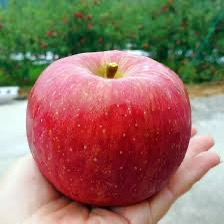
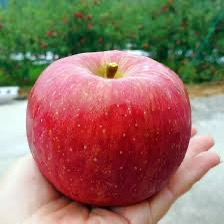
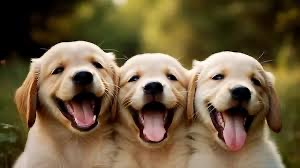
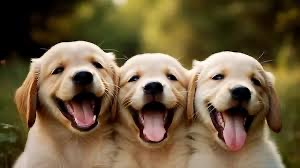
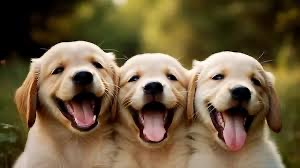
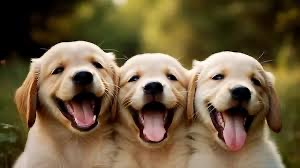

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 624, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 2019, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1566, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 8

bot생성 답변:  1. Dog on the left: Beige
2. Dog in the middle: Beige
3. Dog on the right: Beige
[{'role': 'system', 'content': 'You are an intelligent conversational chatbot. Your role is to engage in friendly and informative general conversations with users. Follow these rules:\n      1. Respond in a professional yet approachable tone.\n      2. If the user asks a factual question, provide accurate and concise answers.\n      3. For casual conversations, engage in a natural and conversational manner.\n      4. If you don’t know the answer, politely admit it and offer to help in another way.\n      5. Do not initiate conversation on your own.\n      6. Provide expert-level advice on scientific, technical, and academic questions.\n      7. When answering, try to generate your answers within 3 sentences.\n'}, {'role': 'user', 'content': [{'type': 'text', 'text': 'What is this?'}]}, {'role': 'assistant', 'content': "The image features a close-up view of a fresh, red apple held in a person's h
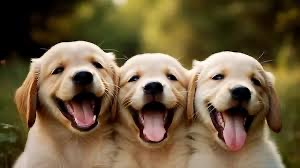

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 624, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 2019, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1566, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 8

In [ ]:
demo.launch(debug=True)